# railファイル確認用

In [13]:
import boto3
import os
import shelve
import copy
import streamlit as st
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import pandas as pd
import numpy as np
import datetime
# import src.utilsST_01 as utlst
import src.helpers as helpers
import src.visualize as vis
from src.config import appProperties
from src.trolley import trolley
from src.similar_pixel import pixel

config = appProperties('config.yml')

In [26]:
dir_area = "Chuo_01_Tokyo-St_up_20230201_knight"
camera_num = "HD11"
target_dir = config.image_dir + "/" + dir_area + "/" + camera_num
outpath = config.output_dir + "/" + dir_area + "/" + camera_num

base_images = helpers.list_images(target_dir)

rail = shelve.open(outpath + "/rail.shelve")

In [3]:
keys = rail.keys()
for i, key in enumerate(keys):
    print(f'{i}: {key}')

0: name
1: HD11


In [4]:
keys = rail[camera_num].keys()
for i, key in enumerate(keys):
    print(f'{i}: {key}')

0: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022312.jpg
1: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022313.jpg
2: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022314.jpg
3: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022315.jpg
4: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022316.jpg
5: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022317.jpg
6: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022318.jpg
7: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022319.jpg
8: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022320.jpg
9: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022321.jpg
10: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022322.jpg
11: imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022323.jpg
12: imgs/Chuo_01_Tokyo-St_up_20230201_

In [5]:
image_path = base_images[0]
image_path

'imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022312.jpg'

In [6]:
keys = rail[camera_num][image_path].keys()
for i, key in enumerate(keys):
    print(f'{i}: {key}')

0: trolley1
1: trolley2
2: trolley3


In [7]:
keys = rail[camera_num][image_path]["trolley1"].keys()
for i, key in enumerate(keys):
    print(f'{i}: {key}')

0: trolley_id
1: isInFrame
2: ix
3: estimated_upper_edge
4: estimated_lower_edge
5: estimated_width
6: estimated_slope
7: blightness_center
8: blightness_mean
9: blightness_std
10: y_init_u
11: y_init_l
12: num_obs
13: missingCounts
14: initial_state_covariance
15: initial_state_mean
16: transition_matrix
17: transition_covariance
18: kf_multi
19: current_state
20: last_state
21: last_state_covariance
22: estimated_upper_edge_variance
23: estimated_lower_edge_variance
24: estimated_slope_variance
25: measured_upper_edge
26: measured_lower_edge
27: missing_state
28: trolley_end_reason
29: brightness
30: new_measurement
31: mask
32: center
33: last_boundary_expectation
34: last_brightness
35: mxn_slope_iy
36: value_iy
37: box_width
38: search_list
39: upper_line
40: lower_line
41: upper_diff
42: lower_diff
43: w_ear
44: as_aj
45: upper_boundary
46: lower_boundary
47: avg_brightness
48: sigmoid_edge_u
49: sigmoid_edge_l
50: last_upper_line
51: last_lower_line
52: edge_std_list_u
53: edge_

In [10]:
image_path = base_images[1]
rail["HD11"][image_path]["trolley1"]["estimated_upper_edge"]

[1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1142,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1143,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1144,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1145,
 1146,
 1146,
 1146,
 1146,
 1146,
 1146,
 1146,
 1146,
 1146,
 1146,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1147,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1148,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1149,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1150,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1151,
 1152,
 1152,
 1152,
 1152,
 1152,
 1152,
 1152,
 1152,
 1153,
 1153,
 1153,
 1153,
 1153,
 1153,
 1153,
 1153,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,
 1154,

imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022312.jpg
imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022313.jpg
imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022314.jpg
imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022315.jpg
imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022316.jpg


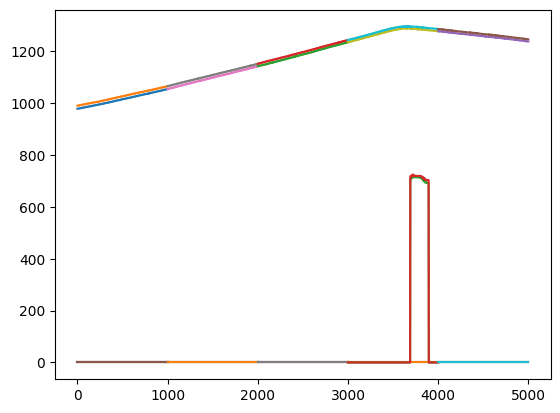

2023-05-24 00:43:46.319664 Process end :0:00:59.328834


In [14]:
dt01 = datetime.datetime.now()

img_num = 5
for idx in range(img_num):
    image_path = base_images[idx]
    print(image_path)
    for trolley_id in config.trolley_ids:
        x = [n + 1000 * idx for n in rail[camera_num][image_path][trolley_id]["ix"]]
        plt.plot(x, rail[camera_num][image_path][trolley_id]["estimated_upper_edge"])
        plt.plot(x, rail[camera_num][image_path][trolley_id]["estimated_lower_edge"])
plt.show()

dt02 = datetime.datetime.now()
prc_time = dt02 - dt01
print(str(datetime.datetime.now()) + f' Process end :{prc_time}')

0> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022312.jpg
1> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022313.jpg
2> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022314.jpg
3> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022315.jpg
4> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022316.jpg
break


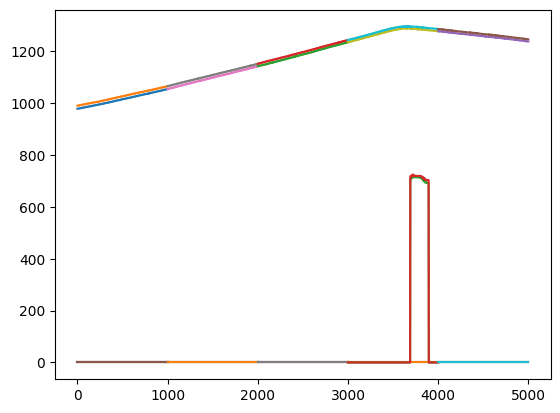

2023-05-24 02:26:04.839173 Process end :0:00:47.165784


In [22]:
'''
case1: xのみnp.array -> 2023-05-24 00:44:31.574638 Process end :0:00:45.240699
case2: x,yをnp.array -> 2023-05-24 02:24:05.555617 Process end :0:00:57.180313
'''

dt01 = datetime.datetime.now()

img_num = 5

for idx, image_path in enumerate(base_images):
    print(f"{idx}> {image_path}")
    x_values = np.array([n + 1000 * idx for n in rail[camera_num][image_path][trolley_id]["ix"]])
    for trolley_id in config.trolley_ids:
        plt.plot(x_values, rail[camera_num][image_path][trolley_id]["estimated_upper_edge"])
        plt.plot(x_values, rail[camera_num][image_path][trolley_id]["estimated_lower_edge"])
    if idx >= img_num-1:
        print("break")
        break

plt.show()

dt02 = datetime.datetime.now()
prc_time = dt02 - dt01
print(str(datetime.datetime.now()) + f' Process end :{prc_time}')

0> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022312.jpg
1> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022313.jpg
2> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022314.jpg
3> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022315.jpg
4> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022316.jpg
5> imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022317.jpg


KeyError: 'ix'

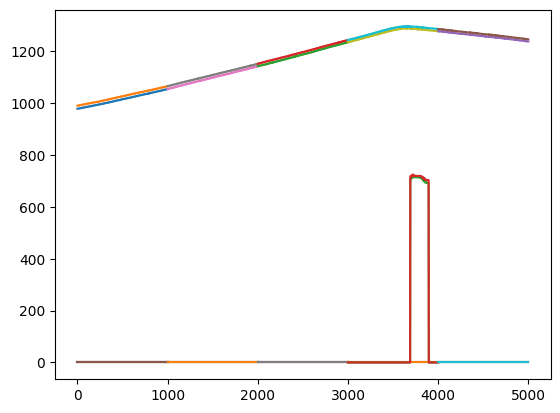

In [30]:
'''
case1: xのみnp.array -> 2023-05-24 00:44:31.574638 Process end :0:00:45.240699
case2: x,yをnp.array -> 2023-05-24 02:24:05.555617 Process end :0:00:57.180313
case3: rail_dict化   -> 
'''

dt01 = datetime.datetime.now()

img_num = 10

rail_dict = copy.deepcopy(rail[camera_num])

for idx, image_path in enumerate(base_images):
    print(f"{idx}> {image_path}")
    x_values = np.array([n + 1000 * idx for n in rail_dict[image_path][trolley_id]["ix"]])
    for trolley_id in config.trolley_ids:
        plt.plot(x_values, rail_dict[image_path][trolley_id]["estimated_upper_edge"])
        plt.plot(x_values, rail_dict[image_path][trolley_id]["estimated_lower_edge"])
    if idx >= img_num-1:
        print("break")
        break

plt.show()

dt02 = datetime.datetime.now()
prc_time = dt02 - dt01
print(str(datetime.datetime.now()) + f' Process end :{prc_time}')

In [28]:
rail_dict = copy.deepcopy(rail_dict[camera_num])
rail_dict

KeyError: 'HD11'

imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022312.jpg
imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022313.jpg
imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022314.jpg
imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022315.jpg
imgs/Chuo_01_Tokyo-St_up_20230201_knight/HD11/2022_0615_HD11_01_00022316.jpg
plotting


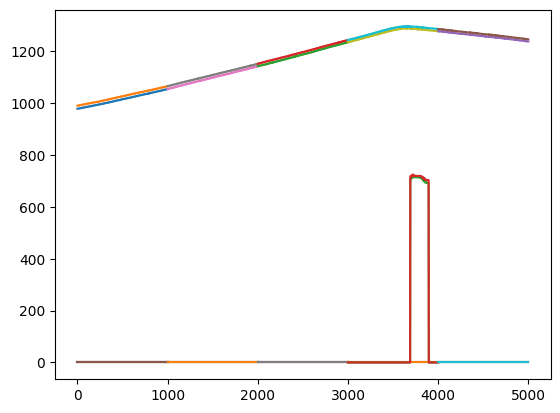

2023-05-24 00:45:38.363092 Process end :0:01:06.779052


In [16]:
dt01 = datetime.datetime.now()

img_num = 5

# プロット用のデータを準備する
plot_data = []
for idx in range(img_num):
    image_path = base_images[idx]
    print(image_path)
    for trolley_id in config.trolley_ids:
        x = [n + 1000 * idx for n in rail[camera_num][image_path][trolley_id]["ix"]]
        plot_data.append((x, rail[camera_num][image_path][trolley_id]["estimated_upper_edge"]))
        plot_data.append((x, rail[camera_num][image_path][trolley_id]["estimated_lower_edge"]))

# 一度にプロットする
print("plotting")
for data in plot_data:
    x, y = data
    plt.plot(x, y)

# グラフを表示する
plt.show()

dt02 = datetime.datetime.now()
prc_time = dt02 - dt01
print(str(datetime.datetime.now()) + f' Process end :{prc_time}')

In [19]:
rail.close()